In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from hfsolver import solver, z32
from becpy.functions import g32

In [4]:
rcpars = {'figure.dpi': 110,
          'axes.grid': True,
#           'figure.figsize': [6,4],
#           'font.size': 18,
#           'text.usetex': True,
#           'axes.labelsize': 22,
#           'xtick.labelsize': 18,
#           'ytick.labelsize': 18,
          
         }
plt.rcParams.update(rcpars)

In [5]:
from becpy.physics import pi, Na, hbar, kB
mass = Na.mass
g_int = Na.g_int
omega_ho = 2*pi * 59.3


l_therm = lambda T: np.sqrt((2*pi*hbar**2)/(mass*kB*T))
n_crit = lambda T: z32/l_therm(T)**3
_alpha = lambda T: g_int/(l_therm(T)**3 * kB*T)


# Solution in the non-condensed case

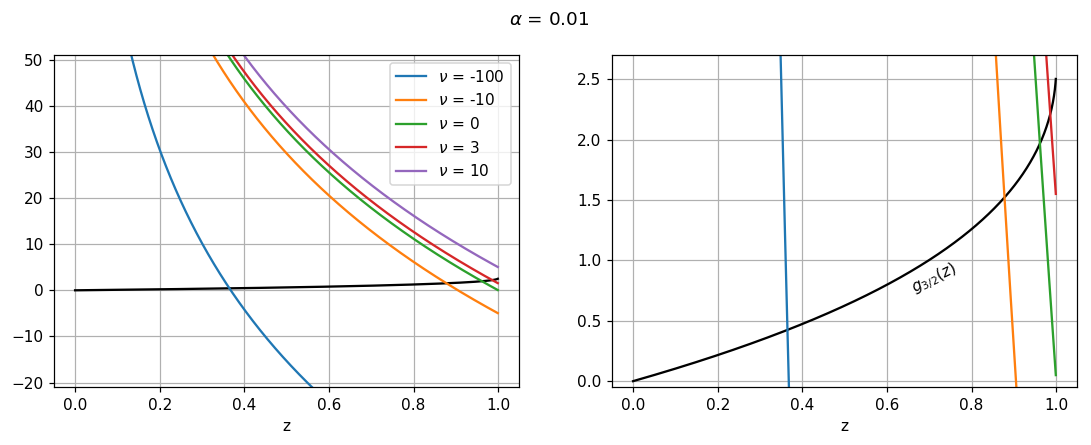

In [6]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))

alpha = 0.01

y = np.linspace(1e-6, 1-1e-3, int(1e4))
g = g32(y)

angle = 90-np.degrees(np.arctan(np.gradient(g, y)))
x_text = 0.65
j = np.argmin(np.abs(y-x_text))
y_text = g[j]*1

ax1.annotate('$g_{3/2}(z)$', xy=(x_text, y_text), rotation=angle[j])

for ax in ax0, ax1:
    
    ax.plot(y, g, 'k')
    for nu in (-100, -10, 0, 3, 10):

        q = nu/2 - np.log(y)/(2*alpha)
        ax.plot(y, q, label='$\\nu$ = %g'%nu)
    
    ax.set_xlabel('z')
    # format_ticklabels(ax)

fig.suptitle('$\\alpha$ = %g'%alpha)
ax0.set_ylim(-21, 51)
ax0.legend()
    
ax1.set_ylim(-0.05, 2.7)

fig.savefig('figures/fig_solve_noncond.png', bbox_inches='tight', dpi=180)



# Solution in the condensed case

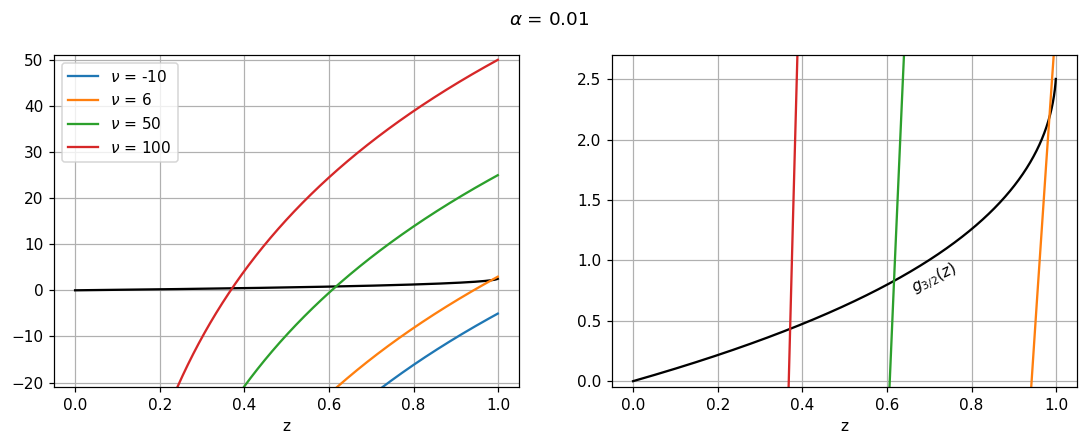

In [7]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))

alpha = 0.01

y = np.linspace(1e-6, 1-1e-3, int(1e4))
g = g32(y)

angle = 90-np.degrees(np.arctan(np.gradient(g, y)))
x_text = 0.65
j = np.argmin(np.abs(y-x_text))
y_text = g[j]*1

ax1.annotate('$g_{3/2}(z)$', xy=(x_text, y_text), rotation=angle[j])

for ax in ax0, ax1:
    
    ax.plot(y, g, 'k')
    for nu in (-10, 6, 50, 100):

        q = nu/2 + np.log(y)/(2*alpha)
        ax.plot(y, q, label='$\\nu$ = %g'%nu)
    
    ax.set_xlabel('z')
    ## format_ticklabels(ax)

fig.suptitle('$\\alpha$ = %g'%alpha)
ax0.set_ylim(-21, 51)
ax0.legend()
    
ax1.set_ylim(-0.05, 2.7)

fig.savefig('figures/fig_solve_cond.png', bbox_inches='tight', dpi=180)



# n(mu)

In [19]:
nus = np.arange(-5, 10, .1)
x_t = np.empty(nus.shape)
x_c = np.empty(nus.shape)

alpha = 0.05
for j, nu in enumerate(nus):
#     print(nu)
    x_t[j], x_c[j] = solver(nu, alpha)

/home/carmelo/UNITN/computationals/hfsolver/hfsolver/solver.py:17: RuntimeWarning: divide by zero encountered in log
  ret = _g32(z) - nu/2 + eta*np.log(z)/(2*alpha)


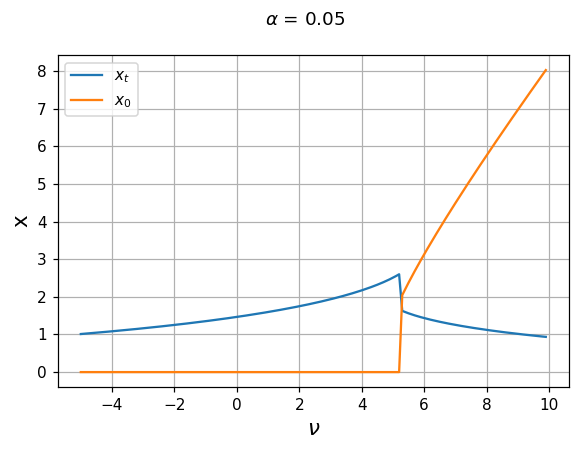

In [20]:
fig, ax = plt.subplots()

fig.suptitle('$\\alpha$ = %g'%alpha)

ax.plot(nus, x_t, label='$x_t$')
ax.plot(nus, x_c, label='$x_0$')

ax.set_xlabel('$\\nu$', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.legend()

# format_ticklabels(ax, xformat='%d', yformat='%d')

fig.savefig('figures/fig_n_mu.png', bbox_inches='tight', dpi=180)


## Potenziale armonico

In [23]:
mu0 = 130e-9 * kB
T = 300e-9


nc = n_crit(T)
lt = l_therm(T)
alpha = _alpha(T)

dr = 1e-6

V_trap = lambda r: 0.5 * mass * omega_ho**2 * r**2

r = np.arange(0, 80) * dr

nu = (mu0 - V_trap(r))*lt**3/g_int
nu = nu.astype(float)
print(alpha)

# plt.plot(r/dr, nu)
nu[np.argmin(np.abs(r/dr - 38))]
nu[0], nu[-1]

0.00828054726587104


(52.331484794411175, -430.06797187781257)

In [24]:
x_t = np.empty(nu.shape)
x_c = np.empty(nu.shape)

for j, _nu in enumerate(nu):
    x_t[j], x_c[j] = solver(_nu, alpha)

x_tot = x_t + x_c

n = x_tot.astype(float)/lt**3
n0 = x_c.astype(float)/lt**3
cond_frac = n0/n
N = 4*pi*dr*np.sum(n*r**2)
N0 = 4*pi*dr*np.sum(n0*r**2)
print('N atomi: %.3f milioni'%(N*1e-6))
print('Fraz cond globale: %.3f'%(N0/N))

N atomi: 6.711 milioni
Fraz cond globale: 0.676


/home/carmelo/UNITN/computationals/hfsolver/hfsolver/solver.py:17: RuntimeWarning: divide by zero encountered in log
  ret = _g32(z) - nu/2 + eta*np.log(z)/(2*alpha)


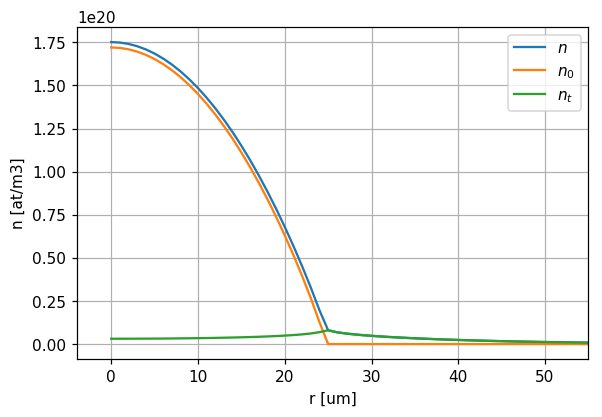

In [29]:
fig, ax = plt.subplots()

ax.plot(r/dr,n, label='$n$')
ax.plot(r/dr,n0, label='$n_0$')
ax.plot(r/dr,n - n0, label='$n_t$')

ax.set_xlim(xmax=55)
# ax.grid()
ax.legend()

ax.set_xlabel('r [um]')
ax.set_ylabel('n [at/m3]')

fig.savefig('figures/fig_harmonic_trap.png', bbox_inches='tight', dpi=180)


# $\alpha, \nu$

In [14]:
from hfsolver.physics import _nu

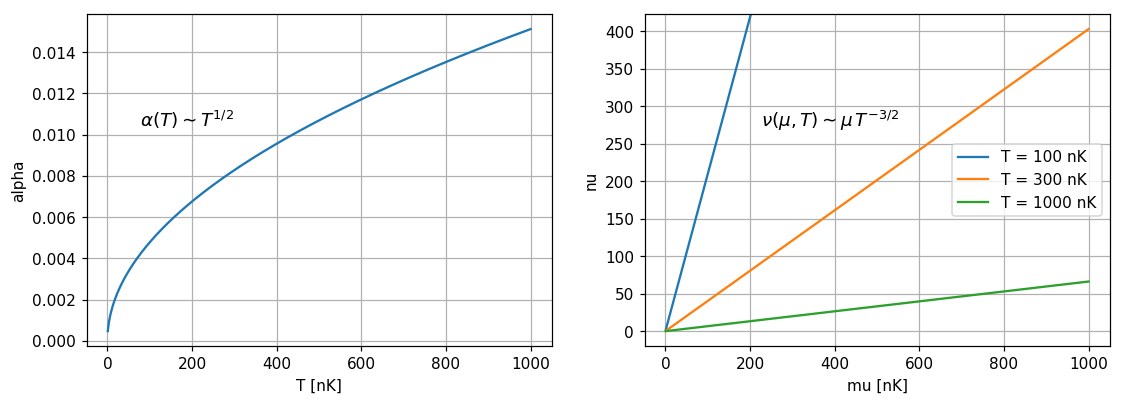

In [15]:
T_range = np.logspace(-9, -6, 1000)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))


ax0.plot(T_range*1e9, _alpha(T_range))
ax0.annotate('$\\alpha(T) \sim T^{1/2}$', xy=(0.115, 0.66), xycoords='axes fraction', fontsize=12)

ax0.set_xlabel('T [nK]')
ax0.set_ylabel('alpha')
# $\nu(\mu, T)$

mu_range = np.logspace(-9, -6, 1000)

for temp in (100, 300, 1000):
    nu_plot = _nu(mu_range*kB, temp*1e-9)
    ax1.plot(mu_range*1e9, nu_plot, label='T = %g nK'%temp)

ax1.set_ylim((-20.05, 422.674))
ax1.annotate('$\\nu(\mu, T) \sim \mu\,T^{-3/2}$', xy=(0.25, 0.66), xycoords='axes fraction', fontsize=12)
ax1.set_xlabel('mu [nK]')
ax1.set_ylabel('nu')

ax1.legend()

fig.savefig('figures/fig_alpha_nu.png', bbox_inches='tight', dpi=180)

In [16]:
ax1.get_ylim()

(-20.05, 422.674)

In [17]:
30*hbar*(2*pi*90)/kB

1.2957960587970647e-07